
**Problem statement**

 To build a CNN based model which can accurately detect melanoma.


**Importing all the important libraries**

In [1]:
# Importing libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

# Importing the Libraries- CNN
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

**Data Reading/Data Understanding**

*Defining the path for train and test images*

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

!unzip "/content/gdrive/MyDrive/CNN_assignment.zip" > /dev/null

In [4]:
# Defining the path 
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [5]:

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("*****Train Image Count*****")
print(image_count_train)
print("===========================")
#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("*****Test Image Count*****")
print(image_count_test)

*****Train Image Count*****
2239
*****Test Image Count*****
118


**Dataset Creation**

Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180

 keras.preprocessing

**Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Train dataset
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writting the datase
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Validation dataset
## Used seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resized images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

Found 2239 files belonging to 9 classes.


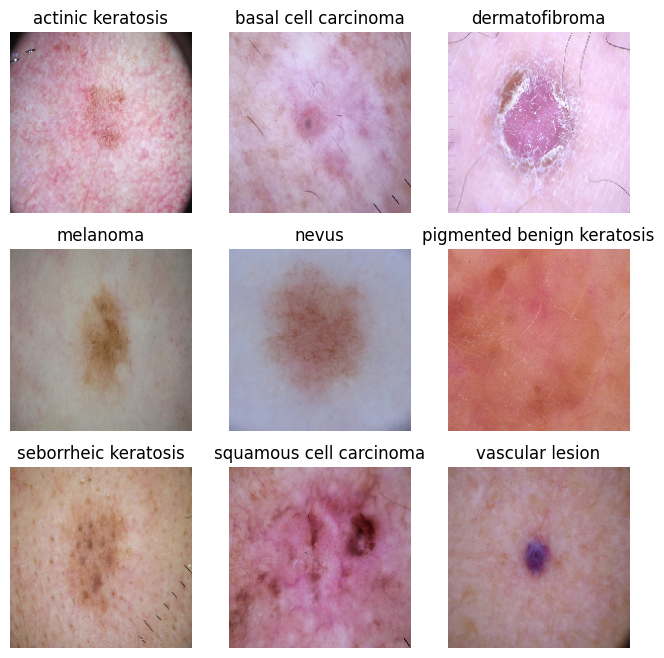

In [10]:
# Visualize one instance of all the class present in the dataset.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

# All the classes of Skin Cancer
class_names = image_dataset.class_names

# Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(8,8))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
num_classes = 9 # As target class has 9 labels

model1 = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

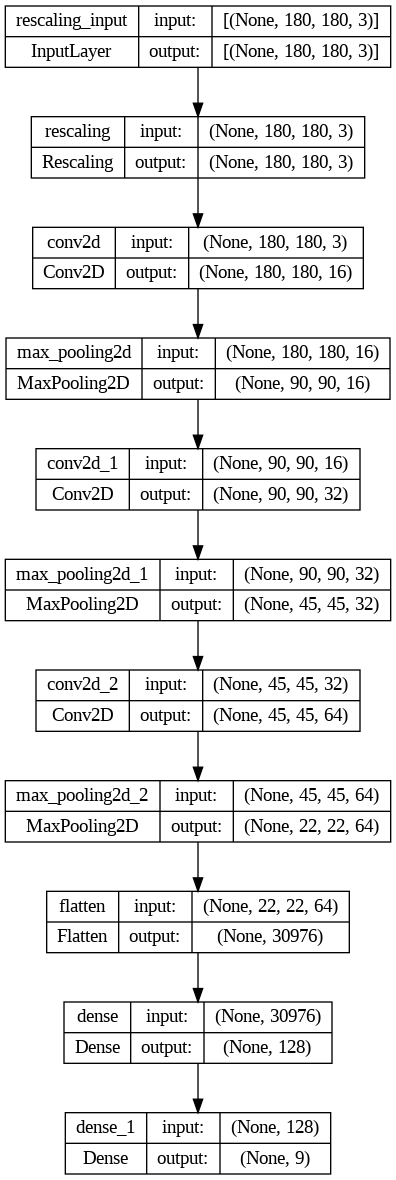

In [15]:
# Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train the model**

In [16]:
epochs = 20
history_model1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 81ms/step - loss: 1.9533 - accuracy: 0.2824 - val_loss: 1.7497 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7345 - accuracy: 0.3728 - val_loss: 1.6839 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5332 - accuracy: 0.4587 - val_loss: 1.4842 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4286 - accuracy: 0.4978 - val_loss: 1.4661 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3028 - accuracy: 0.5480 - val_loss: 1.3838 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2029 - accuracy: 0.5753 - val_loss: 1.3308 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.0969 - accuracy: 0.6127 - val_loss: 1.4952 - val_accuracy: 0.5235
Epoch 8/20
5

**Visualizing training results**

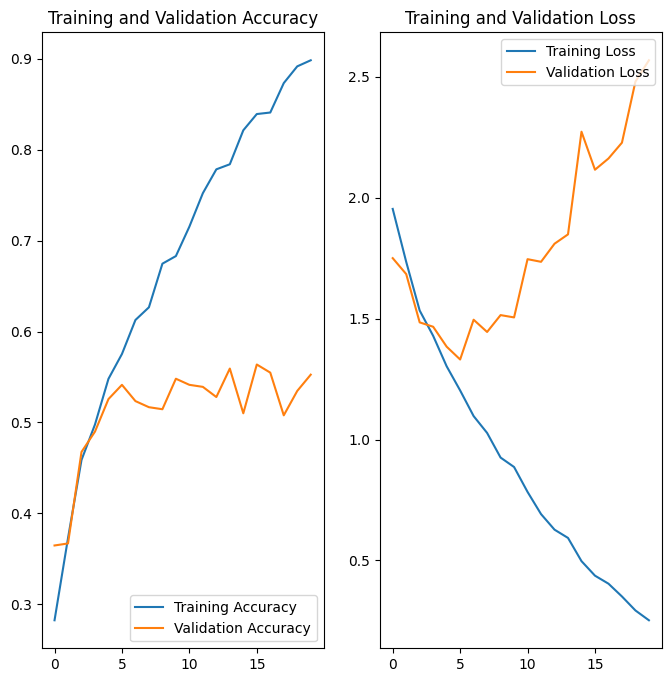

In [17]:
acc = history_model1.history['accuracy']
val_acc = history_model1.history['val_accuracy']

loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Chose an appropriate data augmentation strategy to resolve underfitting/overfitting**

In [18]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])


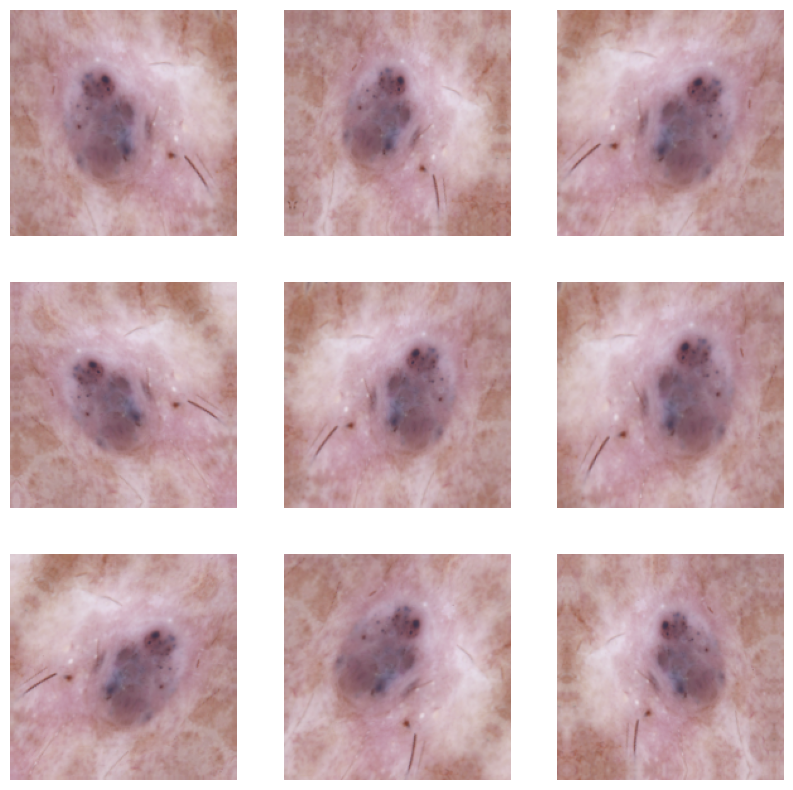

In [19]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Create the model, compile and train the model**

In [20]:
# Here, we have used dropout layer
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compiling the model**

In [21]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

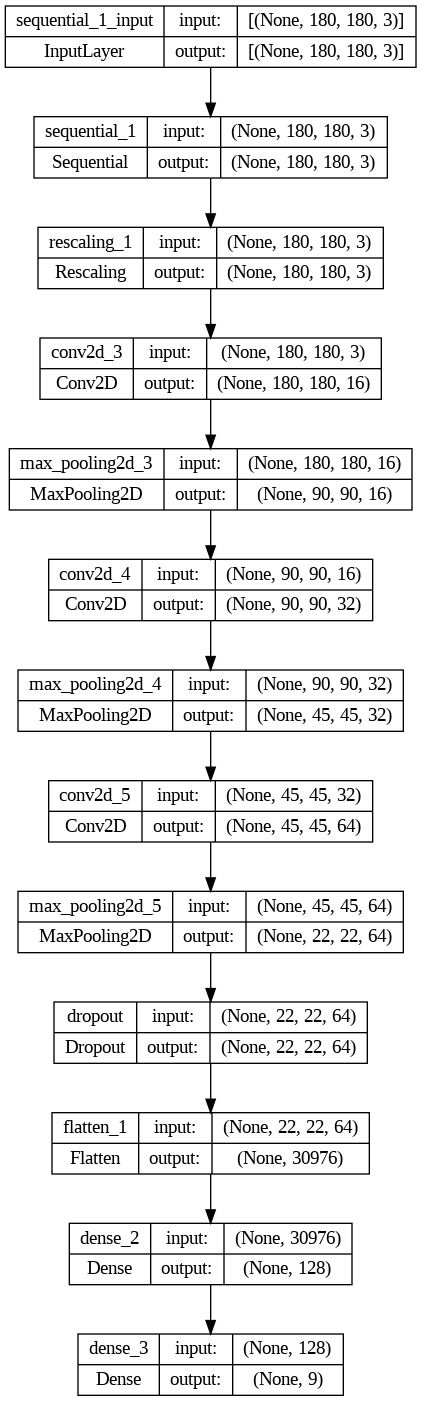

In [23]:
# Vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Training the model**

In [24]:
## Train model for 20 epochs
history_model2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 34ms/step - loss: 2.0479 - accuracy: 0.2740 - val_loss: 1.7054 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6743 - accuracy: 0.4012 - val_loss: 1.6277 - val_accuracy: 0.4362
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6419 - accuracy: 0.4029 - val_loss: 1.5833 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5747 - accuracy: 0.4420 - val_loss: 1.5665 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5373 - accuracy: 0.4515 - val_loss: 1.5742 - val_accuracy: 0.4385
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5047 - accuracy: 0.4665 - val_loss: 1.4590 - val_accuracy: 0.4832
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4411 - accuracy: 0.4888 - val_loss: 1.5639 - val_accuracy: 0.4698
Epoch 8/20
56

**Visualizing the results**

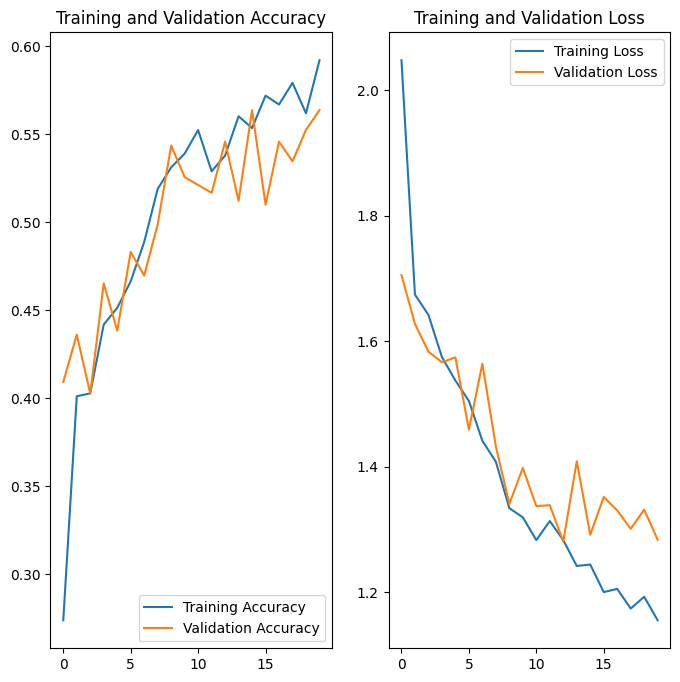

In [25]:
acc = history_model2.history['accuracy']
val_acc = history_model2.history['val_accuracy']

loss = history_model2.history['loss']
val_loss = history_model2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Find the distribution of classes in the training dataset.**

In [26]:
from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
image_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(image_list))

2239


In [27]:
df_dict_original = dict(zip(path_list, image_list))
print(list(df_dict_original.items())[:2])

[('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011136.jpg', 'seborrheic keratosis'), ('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0011185.jpg', 'seborrheic keratosis')]


In [28]:
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
1,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
2,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
3,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
4,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis


In [29]:
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [30]:
original_df[['Label']].value_counts(normalize=True)

Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

**Handling class imbalances**

In [31]:
!pip install Augmentor

In [32]:
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D64252D7E0>: 100%|██████████| 500/500 [00:26<00:00, 18.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D527B2DD20>: 100%|██████████| 500/500 [00:27<00:00, 18.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D516367EB0>: 100%|██████████| 500/500 [00:20<00:00, 24.58 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78D527F639A0>: 100%|██████████| 500/500 [01:53<00:00,  4.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x78D5B7327730>: 100%|██████████| 500/500 [01:37<00:00,  5.12 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D51638D240>: 100%|██████████| 500/500 [00:19<00:00, 25.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78D5D45A0A90>: 100%|██████████| 500/500 [00:48<00:00, 10.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78D5B7304220>: 100%|██████████| 500/500 [00:21<00:00, 23.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78D527C34E50>: 100%|██████████| 500/500 [00:19<00:00, 25.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Image Count After Augmentation")
print(image_count_train)

Image Count After Augmentation
4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]


['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010982.jpg_6f2ba331-58ec-4c9f-929d-76a3af8a9ef4.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_b8459c8f-87e9-4507-809e-4927ab5b65a3.jpg']

In [35]:
image_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
image_list_new[:2]

['seborrheic keratosis', 'seborrheic keratosis']

In [36]:
dataframe_dict_new = dict(zip(path_list_new, image_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)


<ipython-input-37-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [38]:
# Checking shape of new dataset
new_df.shape

(6739, 2)

In [39]:
# Checking initial records
new_df.head()

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
1,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
2,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
3,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis
4,/content/Skin cancer ISIC The International Sk...,seborrheic keratosis


In [40]:
# Checking Value Counts
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [41]:
# Checking the class distribution after adding 500 samples per label
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Train the model on the data created using Augmentor**

In [42]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [43]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your model (make sure to include normalization)**

In [45]:
model3 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile your model (Choose optimizer and loss function appropriately)**

In [46]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [47]:
# View Model Summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

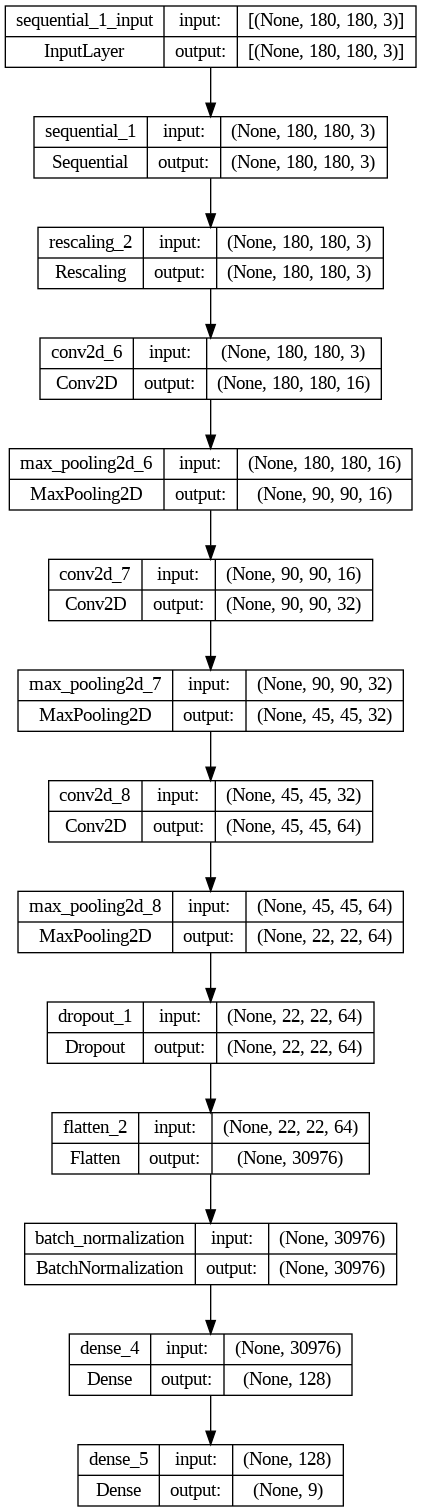

In [48]:
# Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train your model**

In [49]:
epochs = 30
## Your code goes here, use 50 epochs.
history_model3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 51s 269ms/step - loss: 1.6400 - accuracy: 0.3874 - val_loss: 2.2615 - val_accuracy: 0.1507
Epoch 2/30
169/169 [==============================] - 31s 179ms/step - loss: 1.3793 - accuracy: 0.4781 - val_loss: 2.3722 - val_accuracy: 0.2279
Epoch 3/30
169/169 [==============================] - 32s 179ms/step - loss: 1.2733 - accuracy: 0.5271 - val_loss: 1.7138 - val_accuracy: 0.2992
Epoch 4/30
169/169 [==============================] - 31s 181ms/step - loss: 1.2310 - accuracy: 0.5404 - val_loss: 1.8803 - val_accuracy: 0.3630
Epoch 5/30
169/169 [==============================] - 33s 185ms/step - loss: 1.1485 - accuracy: 0.5723 - val_loss: 2.4185 - val_accuracy: 0.3593
Epoch 6/30
169/169 [==============================] - 35s 204ms/step - loss: 1.1114 - accuracy: 0.5807 - val_loss: 1.6109 - val_accuracy: 0.4855
Epoch 7/30
169/169 [==============================] - 36s 210ms/step - loss: 1.0486 - accuracy: 0.6154 - val_loss: 1.4861 - val_ac

**Visualize the model results**

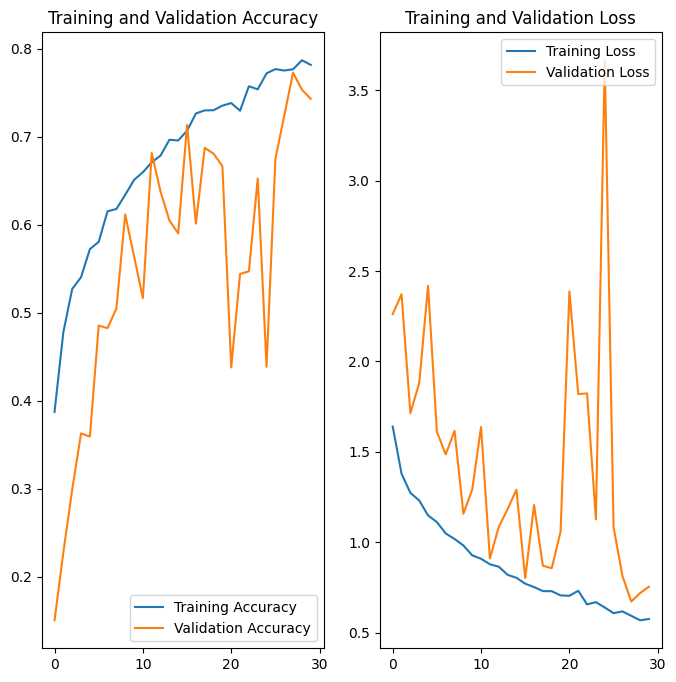

In [50]:
acc = history_model3.history['accuracy']
val_acc = history_model3.history['val_accuracy']

loss = history_model3.history['loss']
val_loss = history_model3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Building Model without Batch Normalization**

In [51]:
model4 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
# Compiling the model
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
# Model Summary
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

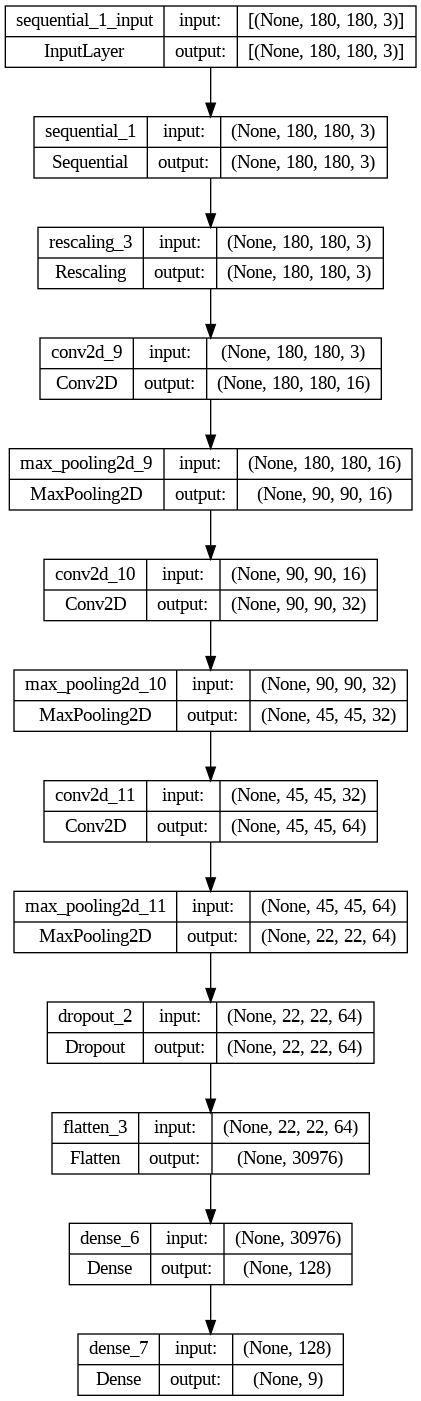

In [54]:
# Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
epochs = 30
## Your code goes here, use 50 epochs.
history_model4 = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 176ms/step - loss: 1.7535 - accuracy: 0.3335 - val_loss: 1.6475 - val_accuracy: 0.3541
Epoch 2/30
169/169 [==============================] - 31s 176ms/step - loss: 1.4461 - accuracy: 0.4564 - val_loss: 1.3905 - val_accuracy: 0.4929
Epoch 3/30
169/169 [==============================] - 31s 176ms/step - loss: 1.3828 - accuracy: 0.4844 - val_loss: 1.3129 - val_accuracy: 0.5071
Epoch 4/30
169/169 [==============================] - 36s 208ms/step - loss: 1.3034 - accuracy: 0.5132 - val_loss: 1.3955 - val_accuracy: 0.4937
Epoch 5/30
169/169 [==============================] - 30s 175ms/step - loss: 1.2400 - accuracy: 0.5378 - val_loss: 1.3321 - val_accuracy: 0.5130
Epoch 6/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1983 - accuracy: 0.5469 - val_loss: 1.1913 - val_accuracy: 0.5546
Epoch 7/30
169/169 [==============================] - 36s 210ms/step - loss: 1.1155 - accuracy: 0.5814 - val_loss: 1.3351 - val_ac

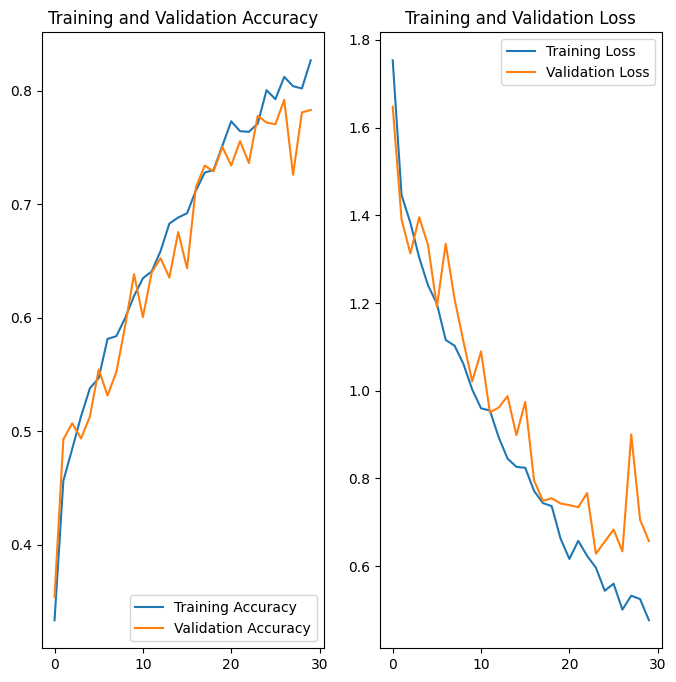

In [56]:
acc = history_model4.history['accuracy']
val_acc = history_model4.history['val_accuracy']

loss = history_model4.history['loss']
val_loss = history_model4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Building Model with other parameters as well as with more layers**

In [57]:
model5 = Sequential()

model5.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model5.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model5.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model5.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model5.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model5.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model5.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model5.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model5.add(layers.Flatten())

#Dense Layer
model5.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model5.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model5.add(layers.Dense(len(class_names),activation='softmax'))


In [58]:
# Compile Model
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
# Viewing Model Summary
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 128)      

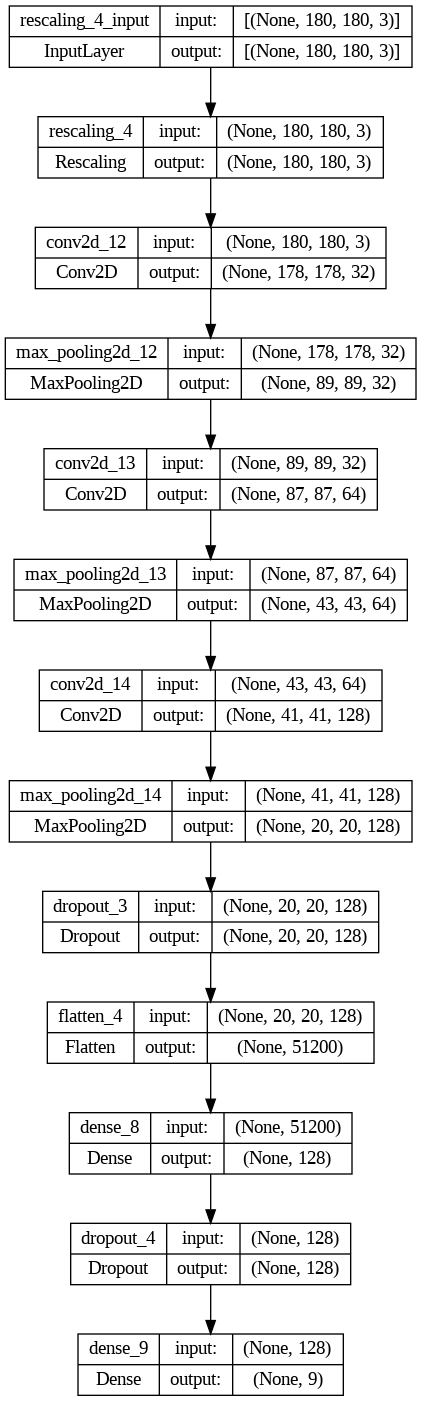

In [60]:
# Visualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [61]:
epochs = 30
## Your code goes here, use 50 epochs.
history_model5 = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 35s 186ms/step - loss: 1.8769 - accuracy: 0.2856 - val_loss: 1.6286 - val_accuracy: 0.3927
Epoch 2/30
169/169 [==============================] - 31s 181ms/step - loss: 1.5411 - accuracy: 0.4039 - val_loss: 1.4218 - val_accuracy: 0.4588
Epoch 3/30
169/169 [==============================] - 37s 212ms/step - loss: 1.3920 - accuracy: 0.4679 - val_loss: 1.3782 - val_accuracy: 0.5011
Epoch 4/30
169/169 [==============================] - 32s 186ms/step - loss: 1.2819 - accuracy: 0.5198 - val_loss: 1.1836 - val_accuracy: 0.5546
Epoch 5/30
169/169 [==============================] - 31s 180ms/step - loss: 1.1675 - accuracy: 0.5571 - val_loss: 1.1620 - val_accuracy: 0.5464
Epoch 6/30
169/169 [==============================] - 36s 210ms/step - loss: 1.0345 - accuracy: 0.6202 - val_loss: 0.9978 - val_accuracy: 0.6154
Epoch 7/30
169/169 [==============================] - 31s 180ms/step - loss: 0.9423 - accuracy: 0.6463 - val_loss: 0.9827 - val_accuracy: 0.6

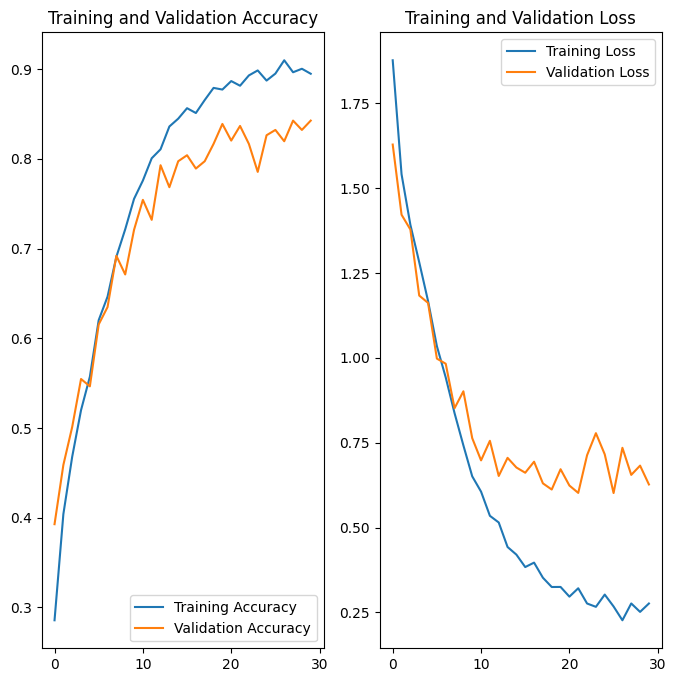

In [62]:
# Visualizing Accuracy
acc = history_model5.history['accuracy']
val_acc = history_model5.history['val_accuracy']

loss = history_model5.history['loss']
val_loss = history_model5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model Prediction**

1/1 [==============================] - 0s 231ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


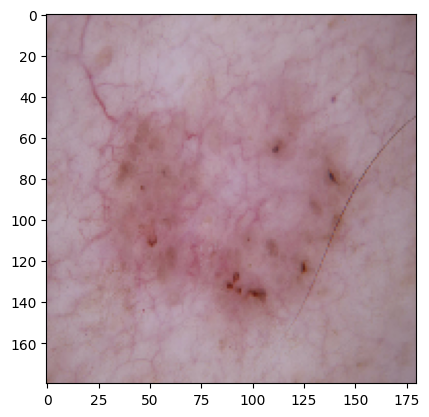

In [63]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model5.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )